In [130]:
import nibabel as nib
import os
import numpy as np
import os.path as op
import scipy
import pandas as pd
import pickle
import scipy.stats
from ipyparallel import Client
from statsmodels.formula.api import ols
import statsmodels.api as sm 
import statsmodels.formula.api as smf
from sklearn import manifold
from sklearn.decomposition import PCA
import seaborn as sns
import moss
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [201]:
rc = Client()

In [2]:
#preliminary housekeeping
home_dir = '/data/home/iballard/fd/'
subj_file = home_dir + 'subjects.txt'
subs = list(np.loadtxt(subj_file,'string'))
os.chdir(home_dir)

In [507]:
masks = ['V1_V2','hipp','peri_sim','para_sim']
roi_names = {'V1_V2':'V1/V2','para_sim':'ParaHipp','peri_sim':'Perirhinal','hipp':'Hippocampus'}
exp = 'sim_4mm-betas'
smooth = 'smoothed'
conds = ['b_plus','b_minus','c_plus','c_minus']
name_map = {'b_plus':'AB+_', 'c_minus':'AC-_','b_minus':'B-_','c_plus':'C+_'}
cond_map = {1:'b_plus',2:'c_minus',3:'b_minus',4:'c_plus'}
nconds = len(cond_map.keys())

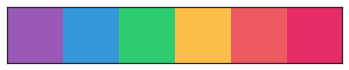

In [36]:
flatui = ["#9b59b6", "#3498db", "#2ecc71","#fcbf4a", "#ed5b61", "#e52c66"]
sns.palplot(sns.color_palette(flatui))

In [21]:
#project a onto b
def vector_reject(a,b): #a gives variance to be
    return a - (np.dot(a,b)/np.dot(b,b)) * b    

# Load and visualize RSA data

In [4]:
#load RSAs from disk
all_rsas = []
for sub in subs:
    out_f = op.join(home_dir,'rsa', sub + 'rsa_sim.pkl')
    pkl_file = open(out_f, 'rb')
    rsa = pickle.load(pkl_file)
    all_rsas.append(rsa)
all_rsas = pd.concat(all_rsas)

In [8]:
fig_rsas = pd.read_csv('/home/iballard/Dropbox/fd/rsa.csv')
fig_rsas = fig_rsas.set_index(['mask','run','sub'])

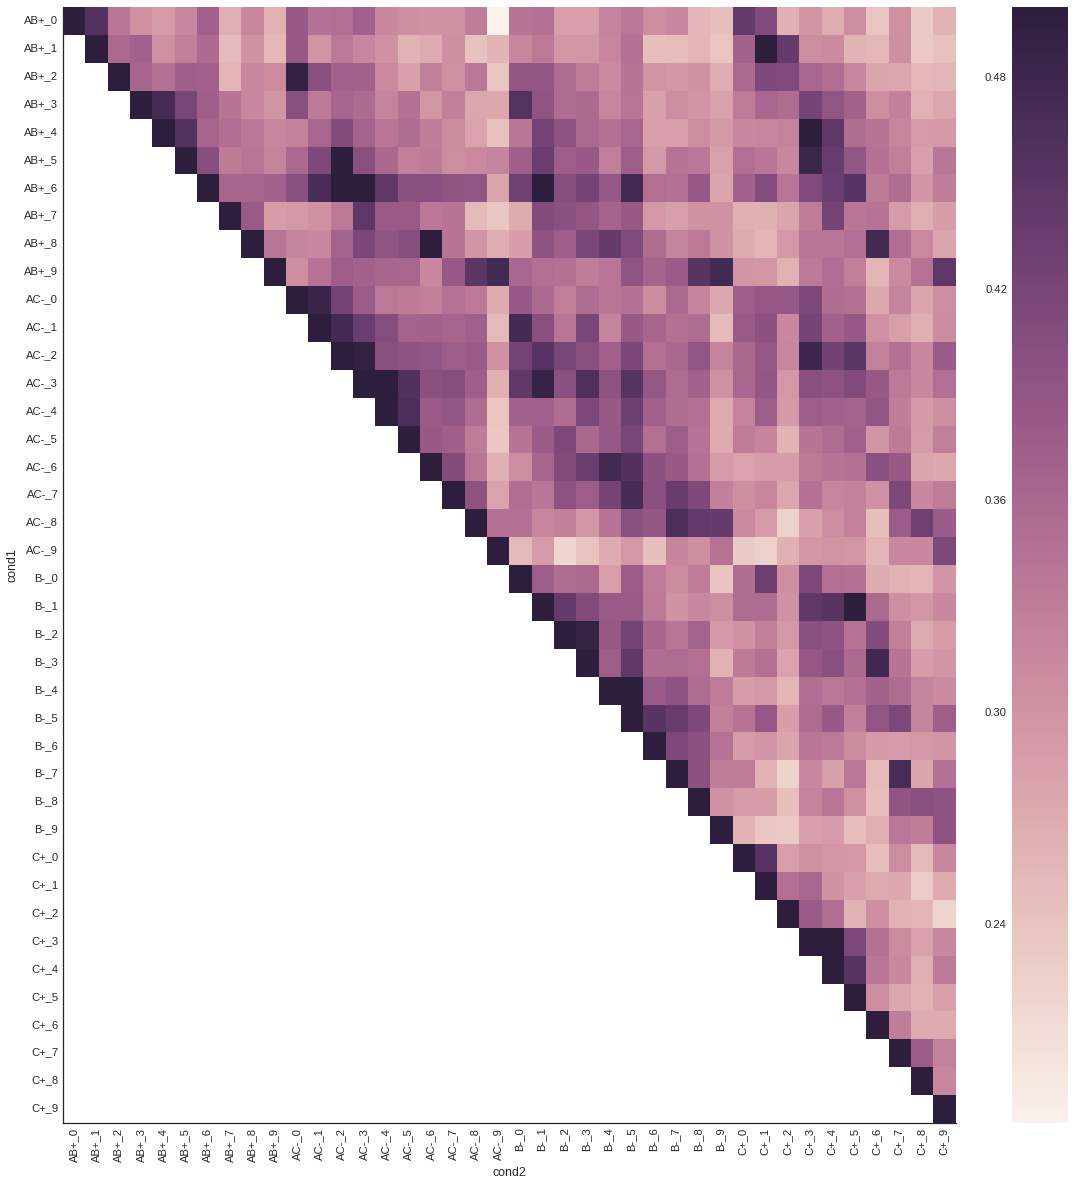

In [38]:
roi = 'V1_V2'
run = 2
plt.title('')
sns.set_context('paper',font_scale = 1.4,rc={"figure.figsize": (20, 20)})
sns.set_style("white")

mean_rsa = fig_rsas.loc[roi,run].groupby(['cond1','cond2']).mean()
mean_rsa = mean_rsa.unstack()['corr']
sns.heatmap(mean_rsa, vmax = .5)
sns.despine()

plt.savefig('/home/iballard/Dropbox/fd/figs/committee_meeting/' + roi + '.svg',dpi = 600)

# Load results of RL modeling

In [10]:
RL_next = pd.read_csv('/home/iballard/fdPE_V_nexttrial.csv')
RL_next = RL_next[RL_next['condition'] != 'feedback']
RL_next = RL_next.set_index(['exp','sub','run','condition'])
RL_next = RL_next.loc[('sim','fd_104')]

RL_std = pd.read_csv('/home/iballard/fdPE_V_trial.csv')
RL_std = RL_std[RL_std['condition'] != 'feedback']
RL_std = RL_std.set_index(['exp','sub','run','condition'])
RL_std = RL_std.loc[('sim','fd_104')]

for i in range(1,4):
    RL_std.loc[i,'trial'] = range(0,40)
RL_std.loc[(2,'c_plus')]

PE  duration  feedback_valence    onset  rew   rt  \
run condition                                                            
2   c_plus    -1.000000         0               NaN   17.013    0  NaN   
    c_plus    -0.600000         0               NaN   34.034    0  NaN   
    c_plus     1.640000         0               NaN   43.041    1  NaN   
    c_plus     0.984000         0               NaN  117.322    1  NaN   
    c_plus     0.590400         0               NaN  143.957    1  556   
    c_plus     0.354240         0               NaN  158.970    1  452   
    c_plus     0.212544         0               NaN  238.049    1  690   
    c_plus     0.127526         0               NaN  302.728    1  578   
    c_plus     0.076516         0               NaN  319.748    1  600   
    c_plus    -1.954090         0               NaN  358.796    0  NaN   

                      V  trial  
run condition                   
2   c_plus     0.000000      1  
    c_plus    -0.400000      3  
    c_plus    -0.640000      4  
    c_plus     0.016000     11  
    c_plus     0.409600     14  
    c_plus     0.645760     15  
    c_plus     0.787456     24  
    c_plus     0.872474     31  
    c_plus     0.923484     33  
    c_plus     0.954090     38

# Conduct RSA Analysis

In [56]:
def get_base_model(sub,mask): 
    reverse_name_map = {'AB+':'b_plus','B-':'b_minus','AC-':'c_minus','C+':'c_plus'}

    overlap_pairs = [['b_plus','b_minus'],
                    ['c_plus','c_minus'],
                    ['b_plus','c_minus']]
    overlap_pairs = [set(x) for x in overlap_pairs] #so order doesnt matter
    not_overlap_pairs = [['c_plus','b_minus'],
                         ['b_plus','c_plus'],
                      ['c_minus','b_minus']]
    not_overlap_pairs = [set(x) for x in not_overlap_pairs] #so order doesnt matter


    singles = [['c_plus','c_plus'],['b_minus','c_plus'], ['b_minus','b_minus']]
    singles = [set(x) for x in singles] #so order doesnt matter
    doubles = [['b_plus','b_plus'], ['b_plus','c_minus'],['c_minus','c_minus']]     
    doubles = [set(x) for x in doubles] #so order doesnt matter
                
    #get dataframe
    sub_rsa = all_rsas.set_index(['mask','sub','run']).sort_index()
    sub_rsa = sub_rsa.loc[(mask,sub)]
    runs = set(sub_rsa.index)

    #initialize model
    model = {'response' : [],
    'valence' : [],
    'identity' : [],
    'time' : [],
    'overlap' : [],
    'value_std' : [],""
    'value_next' : [],
    'nstim':[],
    'pe':[],
    'run_idx' : [], 
    'corr' : [],
    'cond1':[],
    'cond2':[]}
    

    for run in runs:
        for c1, c2, r in zip(sub_rsa.loc[run,'cond1'].values,
                             sub_rsa.loc[run,'cond2'].values,
                             sub_rsa.loc[run,'corr'].values):

            #get variables in tidy format
            cond1, trial1 = c1.split('_')
            cond2, trial2 = c2.split('_')
            cond1 = reverse_name_map[cond1]
            cond2 = reverse_name_map[cond2]

            #get reward codings
            r1 = RL_std.loc[(run,cond1),'rew'].values[trial1]
            r2 = RL_std.loc[(run,cond2),'rew'].values[trial2]
            same = int(r1 == r2)
            val = int(same)
            if r1 < 1.0:
                val = 0
            model['response'].append(same)
            model['valence'].append(val)

            ##identity
            iden= int(cond1 == cond2)
            model['identity'].append(iden)

            #trial diff (in real time)
            t1 = RL_std.loc[(run,cond1),'trial'].values[trial1]
            t2 = RL_std.loc[(run,cond2),'trial'].values[trial2]
            tdiff = abs(t1 - t2)
            model['time'].append(tdiff) 
            
            #number of stimuli
            if set([cond1,cond2]) in singles:
               nstim = -1
            elif set([cond1,cond2]) in doubles:
               nstim = 1
            else:
               nstim = 0
            model['nstim'].append(nstim)
               
            #overlap
            ov = set([cond1,cond2]) in overlap_pairs
            non_ov = set([cond1,cond2]) in not_overlap_pairs
            model['overlap'].append(int(ov) - int(non_ov))

            #value difference
            v1 = RL_std.loc[(run,cond1),'V'].values[trial1]
            v2 = RL_std.loc[(run,cond2),'V'].values[trial2]
            vdiff = -1 * abs(v1 - v2)
            model['value_std'].append(vdiff)
            
            #value difference
            v1 = RL_next.loc[(run,cond1),'V'].values[trial1]
            v2 = RL_next.loc[(run,cond2),'V'].values[trial2]
            vdiff = -1 * abs(v1 - v2)
            model['value_next'].append(vdiff)

            #PE difference
            v1 = RL_std.loc[(run,cond1),'PE'].values[trial1]
            v2 = RL_std.loc[(run,cond2),'PE'].values[trial2]
            vdiff = -1 * abs(v1 - v2)
            model['pe'].append(vdiff)
  
            #run
            model['run_idx'].append(run)

            #corr
            model['corr'].append(r)

            #cond labels
            model['cond1'].append(c1)
            model['cond2'].append(c2)

    model = pd.DataFrame(model)
    return model

In [57]:
#build Data frame for modeling
base = get_base_model('fd_104','hipp')
mask_models={}
for mask in masks:
    all_models = {}

    for sub in subs:
        sub_rsa = all_rsas.set_index(['mask','sub','run'])
        sub_rsa = sub_rsa.loc[(mask,sub)]
        runs = sorted(set(sub_rsa.index))
        
        #deal with uneven number of runs
        base_runs = [1,2,3]
        sub_df = base.copy()
        if len(runs) != len(base_runs): #right number of runs
            bad_runs = set(runs) ^ set(base_runs)
            for bad_run in bad_runs:
                sub_df = sub_df[sub_df['run_idx'] != bad_run]
        all_models[sub] = sub_df

        corr = []
        for run in runs:
            r = sub_rsa.loc[run]['corr'].values
            corr.extend(r)
            
        all_models[sub]['corr'] = corr

    mask_models[mask] = dict(all_models)

/home/iballard/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:52: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/iballard/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:53: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/iballard/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:66: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/iballard/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:67: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/iballard/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:86: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/iballard/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8

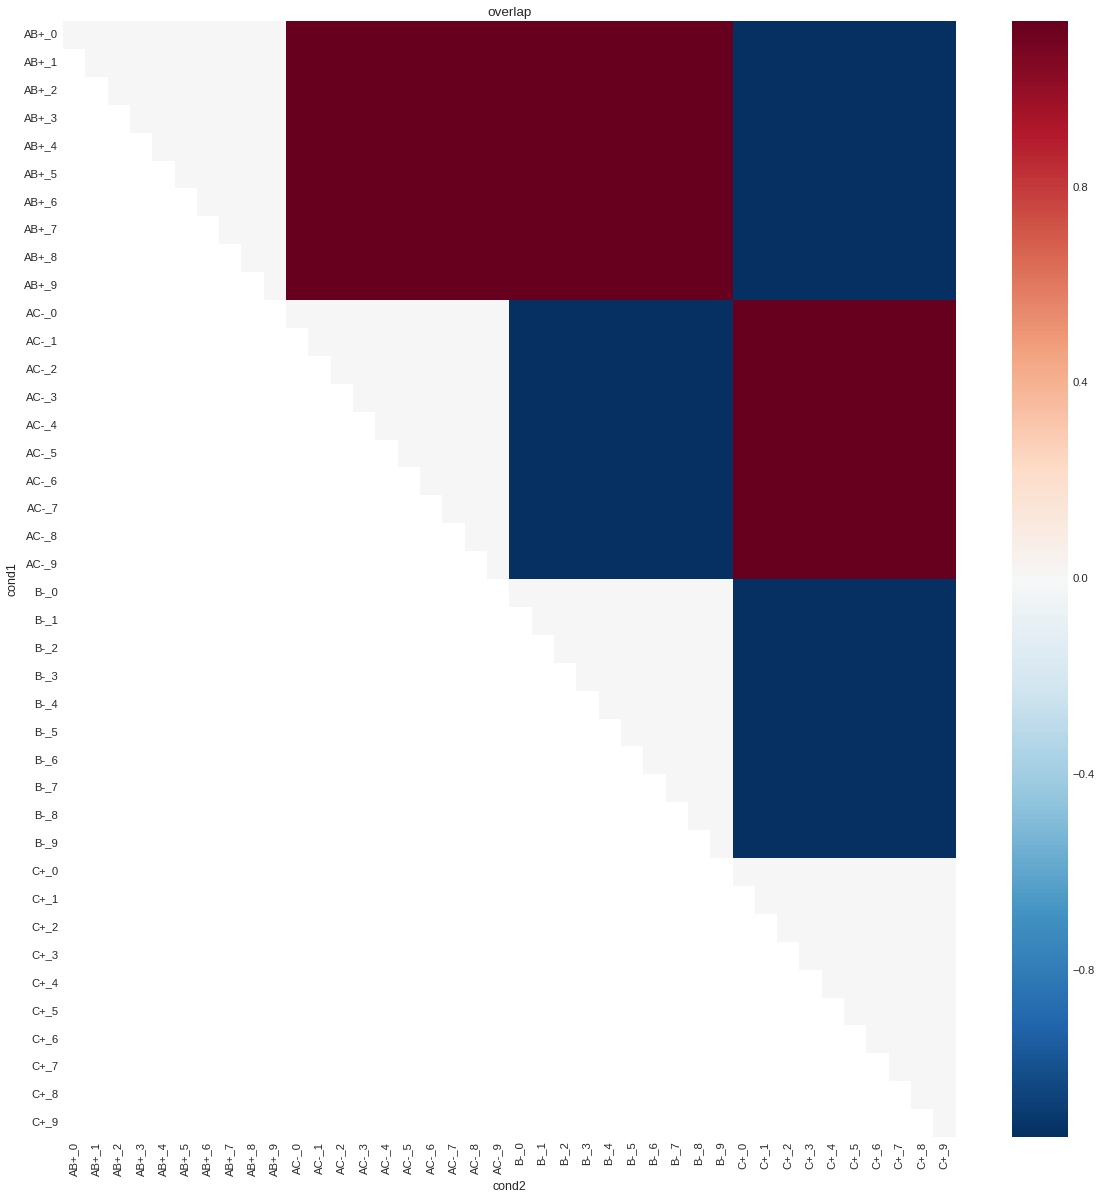

In [103]:
#Visualize regressors for the model of the RSA matrix
tmp  = mask_models['hipp']['fd_104'].copy()
tmp = tmp[tmp['run_idx'] ==3]


x_var = 'overlap'
tmp[x_var] = scipy.stats.zscore(tmp[x_var])
# tmp[x_var] = vector_reject(tmp[x_var].values, tmp['valence'].values)

plt.title('Hippocampus')
sns.set_context('paper',font_scale = 1.4,rc={"figure.figsize": (20, 20)})
sns.set_style("white")


tmp = tmp[['cond1','cond2',x_var]]
new_df = pd.DataFrame()
for cond in ['AB+_','B-_','AC-_','C+_']:
    for i in range(10):
        row = pd.DataFrame({x_var:0,
                            'cond1':cond + str(i),
                            'cond2':cond + str(i)},index = [0])
        new_df = new_df.append(row)
tmp = pd.concat([tmp,new_df])
tmp = tmp.groupby(['cond1','cond2']).mean().unstack()[x_var]
sns.heatmap(tmp)
plt.title(x_var)
# plt.savefig('/home/iballard/Dropbox/fd/figs/committee_meeting/model_' + x_var +'.svg',dpi = 600)

# Run mixed effects model

In [17]:
print masks

['V1_V2', 'hipp', 'peri_sim', 'para_sim']


In [64]:
mfx_masks = ['hipp','V1_V2']

value_regressors = ['value_next','value_std','pe']
regressors = ['response','valence','identity','overlap','pe','value_next','time','time2','nstim']

#set up results dataframe
res = {'intercept':[],'region':[],'sub':[],'run':[]}
for r in regressors:
    res[r] = []

model = []
for mask_idx,mask in enumerate(masks):
    #deal with time
    for n,sub in enumerate(subs):
        m = mask_models[mask][sub].copy()
        m['time'] = scipy.stats.zscore(m['time'])
        m['time2'] = [x**2 for x in m['time']]
        
        #standardize regressors
        for r in regressors:
            m[r] = scipy.stats.zscore(m[r])
        
        #subjects
        m['sub'] = n
        m['mask'] = mask#mask_idx *2 - 1
        
        #clean up dataframe
        all_cols = list(regressors)
        all_cols.extend(['corr','sub','mask'])
        m = m[all_cols]

        #orthogonalize
        for v_regress in value_regressors:
            if v_regress in regressors:
                m[v_regress] = vector_reject(m[v_regress],m['response'])
                m[v_regress] = vector_reject(m[v_regress],m['valence'])

        #process y
        m['corr'] = map(np.arctanh,m['corr'])
        model.append(m.copy())
        
model = pd.concat(model)

#set up model
model_str = ['corr ~ 1']
for r in regressors:
    model_str.append(r)
model_str = '+'.join(model_str)
print model_str

corr ~ 1+response+valence+identity+overlap+pe+value_next+time+time2+nstim


In [509]:
model['roi'] = [roi_names[x] for x in model['mask']]

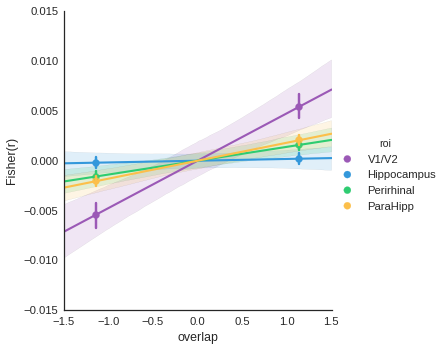

In [511]:
#project out nuisance variables
model = model.set_index(['mask','sub'])
for row in set(model.index):
    
    df = model.loc[row]
    
    model_str = 'corr ~ 1 + response + valence + time + time2 + identity + pe + value_next'
    fit = ols(model_str,df).fit()
    model.loc[row,'resid'] = fit.resid.values
model = model.reset_index()

overlap = model[model['overlap'] != 0]

sns.lmplot(y = 'resid',x= 'overlap',
           x_bins =2,
           x_ci = 68,
           palette = flatui,
           hue = 'roi', data = overlap)
plt.ylabel('Fisher(r)')
plt.savefig('/home/iballard/Dropbox/fd/figs/paper/data_overlap.png', 
            dpi = 300,
           bbox_inches = 'tight')

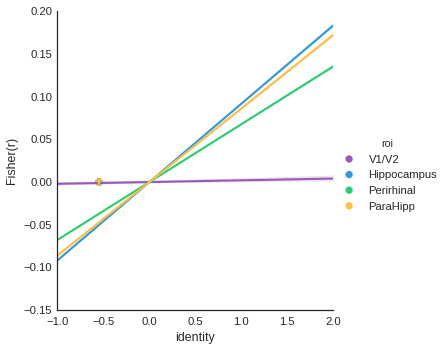

In [512]:
#project out nuisance variables
model = model.set_index(['mask','sub'])
for row in set(model.index):
    
    df = model.loc[row]
    
    model_str = 'corr ~ 1 + response + valence + time + time2 + overlap + pe + value_next'
    fit = ols(model_str,df).fit()
    model.loc[row,'resid'] = fit.resid.values
model = model.reset_index()


sns.lmplot(y = 'resid',x= 'identity', 
           x_bins = 2,
           x_jitter = .3,
           palette = flatui,
           hue = 'roi', data = model)
plt.ylabel('Fisher(r)')

plt.savefig('/home/iballard/Dropbox/fd/figs/paper/data_identity.png', 
            dpi = 300,
           bbox_inches = 'tight')

# Run Permutation Test

In [276]:
model = model.set_index(['mask','sub'])

In [434]:
def permute_data(permuation_number):
    shuffled_params = pd.DataFrame()
    
    #loop through masks and subjects
    for row in set(model.index):
        df = model.loc[row].copy()

        #shuffle
        df['corr'] = np.random.permutation(df['corr'])

        #fit model
        model_str = 'corr ~ 1 + response + valence + time + time2 + pe + value_next + overlap + identity'
        fit = ols(model_str,df).fit()

        #compile results
        new_data = fit.params
        new_data['sub'] = str(row[1])
        new_data['mask'] = row[0]
        shuffled_params = shuffled_params.append(new_data, ignore_index = True)
    
    #save data
    out_f = op.join(op.abspath('../permutation'),'shuffled_' + str(permuation_number) + '.csv')
    shuffled_params.to_csv(out_f,index = False)

In [459]:
# dview = rc[0:52]
# dview.block = True

# dview.push(dict(home_dir=home_dir,
#                 model = model,
#                   ))
# dview.execute("import numpy as np")
# dview.execute("import os.path as op")
# dview.execute("import pandas as pd")
# with dview.sync_imports():
#     import os
#     import numpy
#     import scipy
#     import scipy.stats
#     from statsmodels.formula.api import ols
# n_permutations = 1000
# dview.map_sync(permute_data,np.arange(n_permutations))

# Get means for each regressor

In [498]:
#loop through masks and subjects
fit_params = pd.DataFrame()
for row in set(model.index):
    df = model.loc[row].copy()

    #fit model
    model_str = 'corr ~ 1 + response + valence + time + pe + value_next + time2 + overlap + identity'
    fit = ols(model_str,df).fit()

    #compile results
    new_data = fit.params
    new_data['sub'] = str(row[1])
    new_data['mask'] = row[0]
    fit_params = fit_params.append(new_data, ignore_index = True)
fit_params = fit_params.groupby('mask').mean().reset_index()

In [499]:
#load data
shuffled_params = []
for permuation_number in range(n_permutations):
    out_f = op.join(op.abspath('../fd/permutation'),'shuffled_' + str(permuation_number) + '.csv')
    df = pd.read_csv(out_f)
    df['sample'] = permuation_number
    shuffled_params.append(df)
shuffled_params = pd.concat(shuffled_params)
shuffled_params = shuffled_params.groupby(['mask','sample']).mean().reset_index()

In [501]:
shuffled_params['roi'] = [roi_names[x] for x in shuffled_params['mask']]
fit_params['roi'] = [roi_names[x] for x in fit_params['mask']]

,V1_V2,hipp,para_sim,peri_sim
p,0,0.624,0.003,0.005


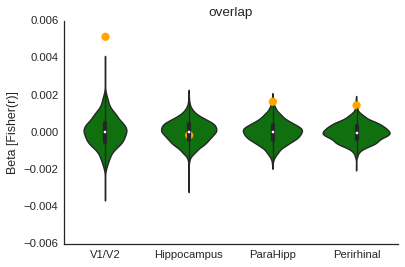

In [520]:
regressor = 'overlap'
ax = sns.violinplot(x = 'roi',y= regressor,
               data = shuffled_params, 
               color = 'green')
sns.pointplot(x = 'roi',y = regressor,
              data = fit_params,
              color = 'orange',
              join = False, ax = ax)
sns.despine()
plt.ylabel('Beta [Fisher(r)]')
plt.xlabel('')
plt.title(regressor)
plt.savefig('/home/iballard/Dropbox/fd/figs/paper/permutation_' + regressor +'.png', 
            dpi = 300,
           bbox_inches = 'tight')
get_p_value(shuffled_params,fit_params,regressor,'>')

In [470]:
def get_p_value(shuffled_params,fit_params,regressor, side):
    p_values = {}
    for m in masks:
        shuff = shuffled_params.set_index('mask').loc[m,regressor]

        val = fit_params.set_index('mask').loc[m,regressor]

        if side == '>':
            p_values[m] = sum(shuff > val)/float(len(shuff))
        elif side == '<':
            p_values[m] = sum(shuff < val)/float(len(shuff))
    return pd.DataFrame(p_values,index = ['p'])

In [523]:
regressor = 'overlap'
other_mask = 'peri_sim'
diff = fit_params_mean.set_index('mask').loc['hipp',regressor] -  fit_params_mean.set_index('mask').loc[other_mask,regressor]
shuffled_differences = shuffled_params_mean.set_index('mask').loc['hipp',regressor].values - shuffled_params_mean.set_index('mask').loc[other_mask,regressor].values
sum(diff > shuffled_differences)/1000.0

0.016